## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
import missingno

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
# all text data, convert numbers to words, only letter, lower case
from num2words import num2words
from ftfy import fix_text
import re


import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

[nltk_data] Downloading package stopwords to /Users/qzx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/qzx/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load the data and check the first few lines
dataset_path = "fake_job_postings.csv"
dataset = pd.read_csv(dataset_path)
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Basic Understanding of the Data

In [3]:
print(dataset.shape)
dataset.info()

(17880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  obje

In [4]:
dataset.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

<Axes: >

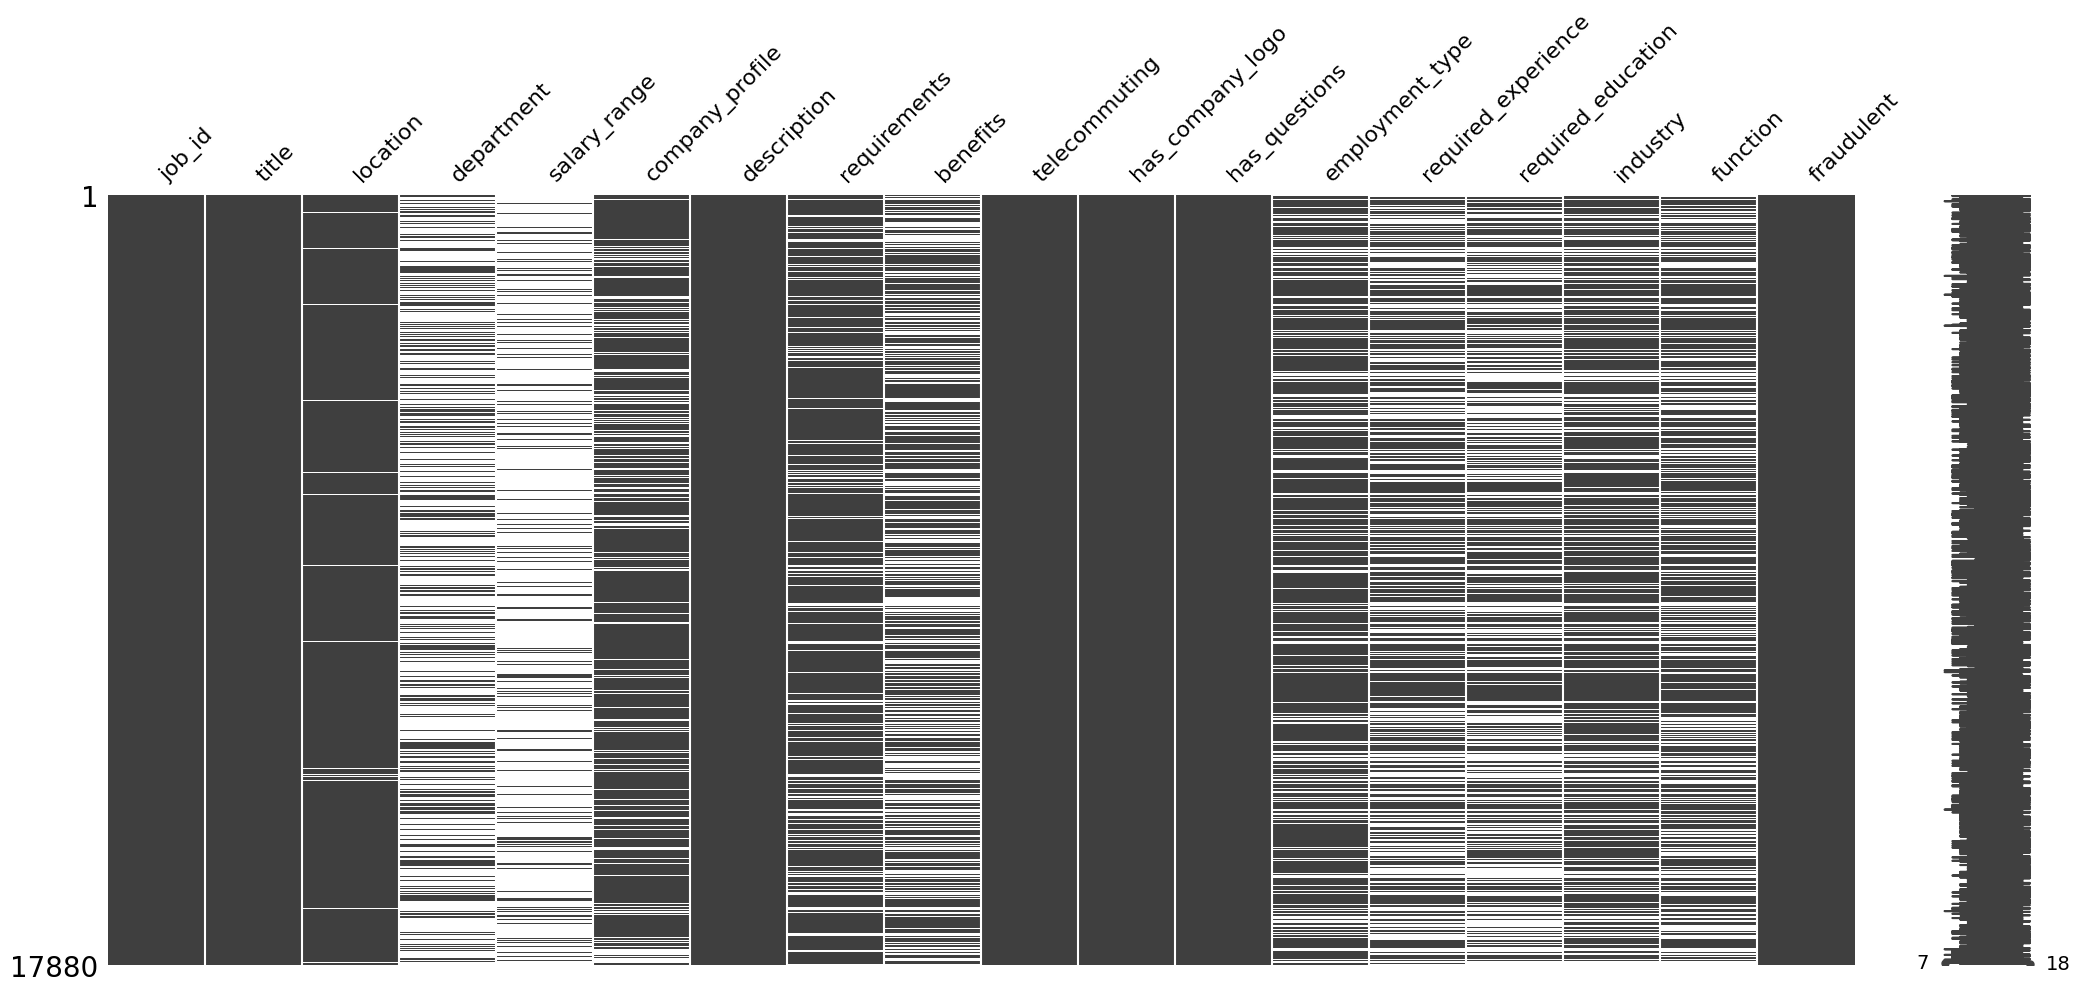

In [5]:
#Alternative way to have a quick glance to check missing values
missingno.matrix(dataset)

In [6]:
dataset.duplicated().sum()

0

From the data, we understand that there are 0 duplicated rows and there are a lot of data columns that has a lot of NA values especially department and salary range. This folows up required_education, benefits and required_experience. We will dive deep to understand each data columns better to make a decision if we want to drop the column or not. 

## 2. Data Cleaning

Columns with missing value: 

location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455

In [7]:
dataset['have_company_profile'] = np.where(dataset['company_profile'].notnull(), 1, 0)
dataset['have_description'] = np.where(dataset['description'].notnull(), 1, 0)
dataset['have_requirements'] = np.where(dataset['requirements'].notnull(), 1, 0)
dataset['have_benefits'] = np.where(dataset['benefits'].notnull(), 1, 0)
dataset['have_department'] = np.where(dataset['department'].notnull(), 1, 0)

In [8]:
# combine texts
dataset[['company_profile']] = dataset[['company_profile']].fillna('')
dataset[['description']] = dataset[['description']].fillna('')
dataset[['requirements']] = dataset[['requirements']].fillna('')
dataset[['benefits']] = dataset[['benefits']].fillna('')
dataset[['department']] = dataset[['department']].fillna('')
dataset['full_text'] = dataset['company_profile'] + ' ' + dataset['description'] + ' ' + dataset['requirements'] + ' ' + dataset['benefits']+ ' ' + dataset['department']

#del dataset['company_profile']
#del dataset['description']
#del dataset['requirements']
#del dataset['benefits']
#del dataset['department']
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,have_company_profile,have_description,have_requirements,have_benefits,have_department,full_text
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0,1,1,1,0,1,"We're Food52, and we've created a groundbreaki..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,1,1,1,1,1,"90 Seconds, the worlds Cloud Video Production ..."
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0,1,1,1,0,0,Valor Services provides Workforce Solutions th...
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,1,1,1,1,1,Our passion for improving quality of life thro...
4,5,Bill Review Manager,"US, FL, Fort Worth",,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,1,1,1,1,0,SpotSource Solutions LLC is a Global Human Cap...


In [9]:
#split location
dataset['location_country'] = dataset['location'].str.split(',').str[0]
dataset['location_county'] = dataset['location'].str.split(',').str[1]
dataset['location_city'] = dataset['location'].str.split(',').str[2]
#del dataset['location']

In [10]:
# fill in with 'unknown': location_country,county,city,employment_type,required_experience,required_education,industry,function
dataset[['employment_type','required_experience','required_education','industry','function','location_country','location_county','location_city']] \
= dataset[['employment_type','required_experience','required_education','industry','function','location_country','location_county','location_city']].fillna('unavailable')

In [11]:
# bin then fill in with most common: salary_group, but still keep salary_range, fill in with 'unknown' and use frequency encoding
dataset['salary_group'] = dataset['salary_range']

In [12]:
for idx in (dataset['salary_group'].dropna()).index:
    Range = dataset.at[idx , 'salary_group'].split('-')
    try :
        starts = int(Range[0])
        if len(Range)==2:
          ends = int(Range[1])
        else:
          ends = starts
        salary = (starts + ends)/2
        if salary <= 1000:
          dataset.at[idx ,'salary_group'] = 'Extremely Low'
        elif salary > 1000 and salary <= 30000:
          dataset.at[idx ,'salary_group'] = 'Low'
        elif salary > 30000 and salary <= 100000:
          dataset.at[idx ,'salary_group'] = 'Slightly Low'
        elif salary > 100000 and salary <= 500000:
          dataset.at[idx ,'salary_group'] = 'Slightly High'
        elif salary > 500000 and salary <= 1000000:
          dataset.at[idx ,'salary_group'] = 'High'
        elif salary > 1000000:
          dataset.at[idx ,'salary_group'] = 'Extremely High'

    except ValueError:
        dataset.at[idx ,'salary_group'] = 'Unavailable'

dataset['salary_group'] = dataset['salary_group'].fillna('Unavailable')
dataset['salary_range'] = dataset['salary_range'].fillna('Unavailable')



In [13]:
def remove_stop_words(doc):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  docs = list(set(doc.split(' ')) - stop_words)
  return docs  # stem
def simple_stemmer(doc):
  stemmer= PorterStemmer()
  doc = ' '.join([stemmer.stem(word) for word in doc])
  return doc

# to clean data
def normalise_text(text):
    text = fix_text(text)
    text = text.lower()  # lowercase
    text = re.sub(r'\#', "", text)        # replaces hashtags
    text = re.sub(r'\xa0', ' ', text) # remove \xa0
    # remove URL addresses
    text = re.sub(r"http\S+","URL", text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'\d+', lambda x: num2words(x.group(), to='cardinal'), text)
    text = re.sub("[^a-zA-Z]", " ", text) # letters only
    # replace more than or equal to two white spaces into one white space.
    text = re.sub(r'\s{2,}', ' ', text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    #stemmer= PorterStemmer()
    #text = ' '.join([stemmer.stem(word) for word in text])
    return text



In [14]:
normalise_text(dataset['full_text'].iloc[0])
dataset['full_text'] = dataset['full_text'].apply(lambda x: normalise_text(x))
dataset['text_len'] = dataset['full_text'].apply(lambda x: len(x.split(' ')))

In [15]:
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,have_company_profile,have_description,have_requirements,have_benefits,have_department,full_text,location_country,location_county,location_city,salary_group,text_len
0,1,Marketing Intern,"US, NY, New York",Marketing,Unavailable,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,unavailable,unavailable,Marketing,0,1,1,1,0,1,foodfifty two created groundbreaking award win...,US,NY,New York,Unavailable,258
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,Unavailable,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,unavailable,Marketing and Advertising,Customer Service,0,1,1,1,1,1,ninety seconds worlds cloud video production s...,NZ,,Auckland,Unavailable,590
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Unavailable,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,unavailable,unavailable,unavailable,unavailable,unavailable,0,1,1,1,0,0,valor services provides workforce solutions me...,US,IA,Wever,Unavailable,232
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,Unavailable,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,1,1,1,1,1,passion improving quality life geography heart...,US,DC,Washington,Unavailable,493
4,5,Bill Review Manager,"US, FL, Fort Worth",,Unavailable,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,1,1,1,1,0,spotsource solutions llc global human capital ...,US,FL,Fort Worth,Unavailable,400


In [16]:
dataset.isna().sum()

job_id                    0
title                     0
location                346
department                0
salary_range              0
company_profile           0
description               0
requirements              0
benefits                  0
telecommuting             0
has_company_logo          0
has_questions             0
employment_type           0
required_experience       0
required_education        0
industry                  0
function                  0
fraudulent                0
have_company_profile      0
have_description          0
have_requirements         0
have_benefits             0
have_department           0
full_text                 0
location_country          0
location_county           0
location_city             0
salary_group              0
text_len                  0
dtype: int64

## 3. Exploratory Data Analysis

- wordcut: title,department,salary_range,industry,function,company_profile,description,requirements,benefits,location

In [17]:
#drop useless column
del dataset['job_id']

In [18]:
dataset.describe()

,telecommuting,has_company_logo,has_questions,fraudulent,have_company_profile,have_description,have_requirements,have_benefits,have_department,text_len
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,0.048434,0.814989,0.999944,0.849217,0.596644,0.354195,272.953300
std,0.202631,0.403492,0.499945,0.214688,0.388317,0.007479,0.357847,0.490585,0.478282,147.869521
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,162.000000
50%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,249.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,353.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1511.000000


### 3.1 Drop columns with low variance

In [19]:
# Filter numeric columns only
numeric_columns = dataset.select_dtypes(include="number")

# Calculate the variance for numeric columns
variance_info = numeric_columns.var()

# Display the variance for each numeric column
print(variance_info)


telecommuting               0.041059
has_company_logo            0.162806
has_questions               0.249945
fraudulent                  0.046091
have_company_profile        0.150790
have_description            0.000056
have_requirements           0.128055
have_benefits               0.240673
have_department             0.228754
text_len                21865.395268
dtype: float64


In [20]:
del dataset['have_description']

### 3.2 Understanding of variables

In [21]:
dataset.title.value_counts().head(5)

title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
Name: count, dtype: int64

In [22]:
dataset.title.str.strip().value_counts().head(5)

title
English Teacher Abroad                                406
Customer Service Associate                            198
Graduates: English Teacher Abroad (Conversational)    144
Customer Service Associate - Part Time                 91
Software Engineer                                      90
Name: count, dtype: int64

In [23]:
dataset.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'have_company_profile', 'have_requirements',
       'have_benefits', 'have_department', 'full_text', 'location_country',
       'location_county', 'location_city', 'salary_group', 'text_len'],
      dtype='object')

In [24]:
#location
dataset.location.value_counts().head(5)

location
GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
Name: count, dtype: int64

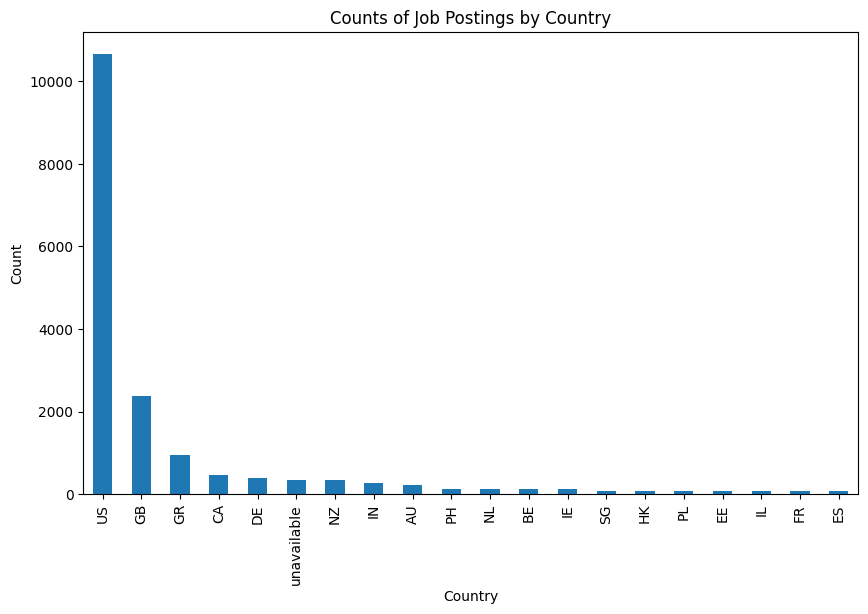

In [25]:
all_ctry = dataset['location_country'].value_counts()

top_20 = dataset['location_country'].value_counts().head(20)

plt.figure(figsize=(10, 6))
top_20.plot(kind='bar')
plt.title('Counts of Job Postings by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


In [26]:
dataset['location_county'].value_counts().head(5)

location_county
        2140
 CA     2051
 NY     1259
 LND     992
 TX      975
Name: count, dtype: int64

In [27]:
dataset['location_city'].value_counts().head(5)

location_city
                  1627
 London           1060
 New York          669
 Athens            543
 San Francisco     478
Name: count, dtype: int64

In [28]:
dataset.department.value_counts().head(5)

department
               11547
Sales            551
Engineering      487
Marketing        401
Operations       270
Name: count, dtype: int64

In [29]:
dataset.salary_range.value_counts().head(5)

salary_range
Unavailable    15012
0-0              142
40000-50000       66
30000-40000       55
45000-67000       37
Name: count, dtype: int64

In [30]:
dataset.company_profile.head(10)

0    We're Food52, and we've created a groundbreaki...
1    90 Seconds, the worlds Cloud Video Production ...
2    Valor Services provides Workforce Solutions th...
3    Our passion for improving quality of life thro...
4    SpotSource Solutions LLC is a Global Human Cap...
5                                                     
6    Founded in 2009, the Fonpit AG rose with its i...
7    Airenvy’s mission is to provide lucrative yet ...
8    Solutions3 is a woman-owned small business who...
9    Novitex Enterprise Solutions, formerly Pitney ...
Name: company_profile, dtype: object

In [31]:
dataset.description.head(10)

0    Food52, a fast-growing, James Beard Award-winn...
1    Organised - Focused - Vibrant - Awesome!Do you...
2    Our client, located in Houston, is actively se...
3    THE COMPANY: ESRI – Environmental Systems Rese...
4    JOB TITLE: Itemization Review ManagerLOCATION:...
5    Job OverviewApex is an environmental consultin...
6    Your Responsibilities: Manage the English-spea...
7    Who is Airenvy?Hey there! We are seasoned entr...
8    Implementation/Configuration/Testing/Training ...
9    The Customer Service Associate will be based i...
Name: description, dtype: object

In [32]:
dataset.requirements.head(10)

0    Experience with content management systems a m...
1    What we expect from you:Your key responsibilit...
2    Implement pre-commissioning and commissioning ...
3    EDUCATION: Bachelor’s or Master’s in GIS, busi...
4    QUALIFICATIONS:RN license in the State of Texa...
5                                                     
6    Your Know-How:                                ...
7    Experience with CRM software, live chat, and p...
8    MUST BE A US CITIZEN.An active TS/SCI clearanc...
9    Minimum Requirements:Minimum of 6 months custo...
Name: requirements, dtype: object

In [33]:
dataset.benefits.head(10)

0                                                     
1    What you will get from usThrough being part of...
2                                                     
3    Our culture is anything but corporate—we have ...
4                                Full Benefits Offered
5                                                     
6    Your Benefits: Being part of a fast-growing co...
7    Competitive Pay. You'll be able to eat steak e...
8                                                     
9                                                     
Name: benefits, dtype: object

In [34]:
dataset.telecommuting.value_counts().head(5)

telecommuting
0    17113
1      767
Name: count, dtype: int64

In [35]:
dataset.has_company_logo.value_counts().head(5)

has_company_logo
1    14220
0     3660
Name: count, dtype: int64

In [36]:
dataset.has_questions.value_counts().head(5)

has_questions
0    9088
1    8792
Name: count, dtype: int64

In [37]:
dataset.employment_type.value_counts().head(5)

employment_type
Full-time      11620
unavailable     3471
Contract        1524
Part-time        797
Temporary        241
Name: count, dtype: int64

In [38]:
dataset.required_experience.value_counts().head(5)

required_experience
unavailable         7050
Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Name: count, dtype: int64

In [39]:
dataset.required_education.value_counts().head(5)

required_education
unavailable                  8105
Bachelor's Degree            5145
High School or equivalent    2080
Unspecified                  1397
Master's Degree               416
Name: count, dtype: int64

In [40]:
dataset.industry.value_counts().head(5)

industry
unavailable                            4903
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Name: count, dtype: int64

In [41]:
dataset.function.value_counts().head(5)

function
unavailable               6455
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Name: count, dtype: int64

### 2.2 Relationship between features and classification target

In [42]:
dataset[dataset['fraudulent']==1]['title'].value_counts().head(5)

title
Data Entry Admin/Clerical Positions - Work From Home               21
Home Based Payroll Typist/Data Entry Clerks Positions Available    21
Cruise Staff Wanted *URGENT*                                       21
Customer Service Representative                                    17
Administrative Assistant                                           16
Name: count, dtype: int64

In [43]:
dataset[dataset['fraudulent']==0]['title'].value_counts().head(5)

title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
Name: count, dtype: int64

In [44]:
#department
dataset[dataset['fraudulent']==1]['department'].value_counts().head(5)

department
                          531
Engineering                46
Clerical                   27
Oil & Energy               24
Information Technology     15
Name: count, dtype: int64

In [45]:
dataset[dataset['fraudulent']==0]['department'].value_counts().head(5)

department
               11016
Sales            539
Engineering      441
Marketing        399
Operations       270
Name: count, dtype: int64

In [46]:
#salary_range
dataset[dataset['fraudulent']==1]['salary_range'].value_counts().head(5)


salary_range
Unavailable      643
7200-1380000      10
30000-50000        8
250000-500000      7
28000-32000        6
Name: count, dtype: int64

In [47]:
dataset[dataset['fraudulent']==0]['salary_range'].value_counts().head(5)

salary_range
Unavailable    14369
0-0              138
40000-50000       65
30000-40000       51
45000-67000       37
Name: count, dtype: int64

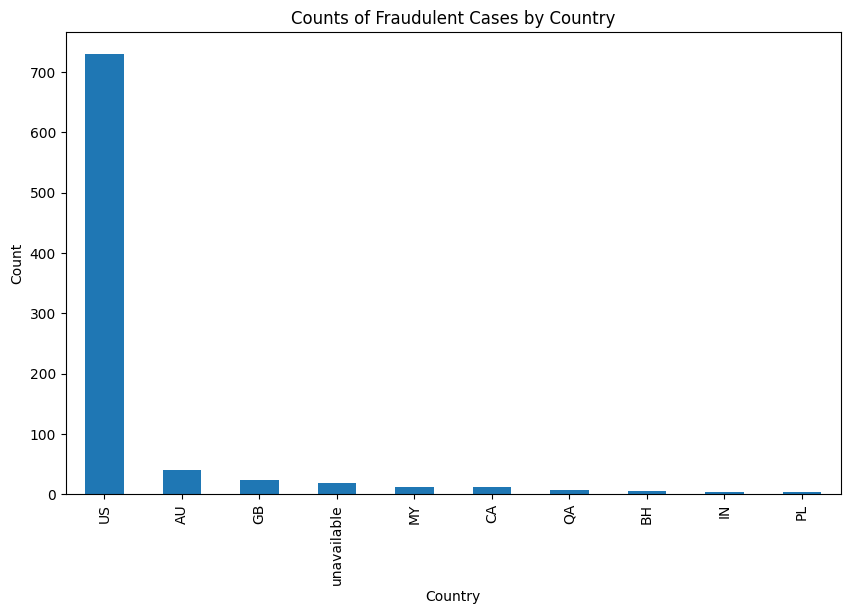

In [48]:
#location
fraudulent_ctry = dataset[dataset['fraudulent'] == 1]['location_country'].value_counts()

fraudulent_ctry_10 = fraudulent_ctry.head(10)

plt.figure(figsize=(10, 6))
fraudulent_ctry_10.plot(kind='bar')
plt.title('Counts of Fraudulent Cases by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90) 
plt.show()

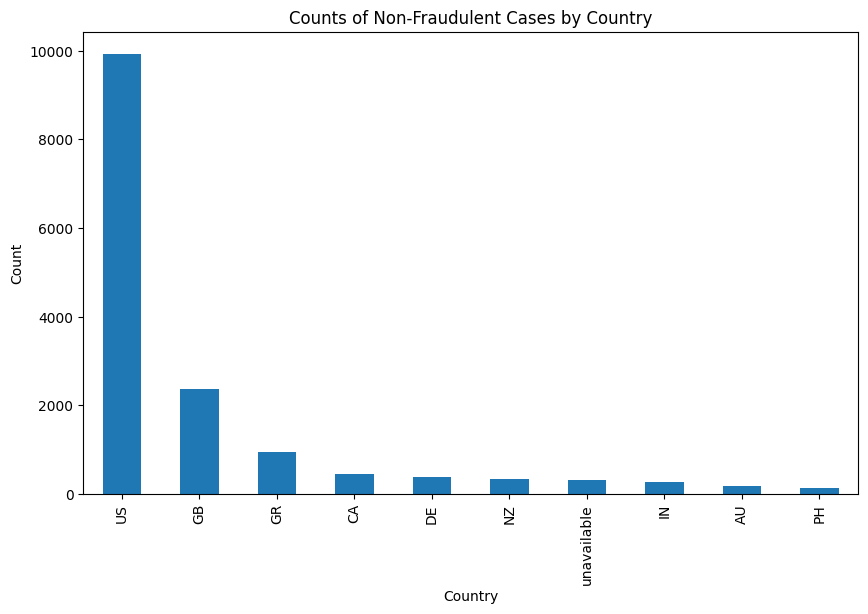

In [49]:
non_fraudulent_ctry = dataset[dataset['fraudulent'] == 0]['location_country'].value_counts()

non_fraudulent_ctry_10 = non_fraudulent_ctry.head(10)

plt.figure(figsize=(10, 6))
non_fraudulent_ctry_10.plot(kind='bar')
plt.title('Counts of Non-Fraudulent Cases by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90) 
plt.show()

In [50]:
dataset[dataset['fraudulent']==1]['location_county'].value_counts().head(5)

location_county
 TX    152
 CA    143
 NY     68
        57
 MD     35
Name: count, dtype: int64

In [51]:
dataset[dataset['fraudulent']==0]['location_county'].value_counts().head(5)

location_county
        2083
 CA     1908
 NY     1191
 LND     986
 TX      823
Name: count, dtype: int64

In [52]:
dataset[dataset['fraudulent']==1]['location_city'].value_counts().head(5)

location_city
                129
 Houston         92
 Sydney          31
 Bakersfield     30
unavailable      27
Name: count, dtype: int64

In [53]:
dataset[dataset['fraudulent']==0]['location_city'].value_counts().head(5)

location_city
                  1498
 London           1056
 New York          649
 Athens            543
 San Francisco     467
Name: count, dtype: int64

<Axes: xlabel='telecommuting'>

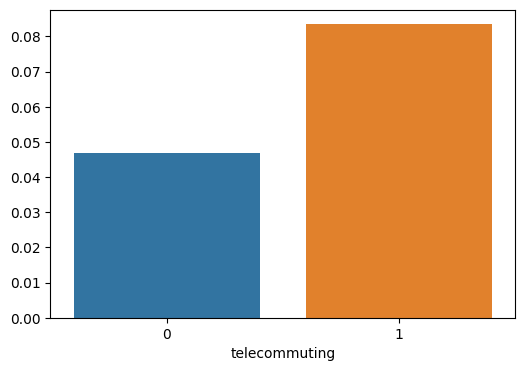

In [54]:
#telecommuting
telecommuting_fraud = dataset.groupby('telecommuting')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=telecommuting_fraud.index, y=telecommuting_fraud.values, ax=ax)

<Axes: xlabel='telecommuting', ylabel='count'>

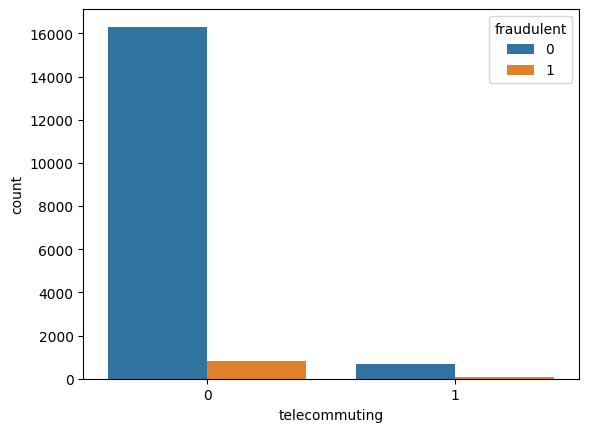

In [55]:
sns.countplot(x='telecommuting',data=dataset,hue='fraudulent')

<Axes: xlabel='has_company_logo'>

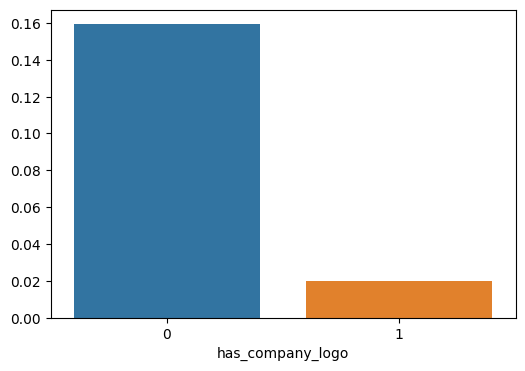

In [56]:
#has_company_logo
has_company_logo_fraud = dataset.groupby('has_company_logo')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=has_company_logo_fraud.index, y=has_company_logo_fraud.values, ax=ax)

<Axes: xlabel='has_company_logo', ylabel='count'>

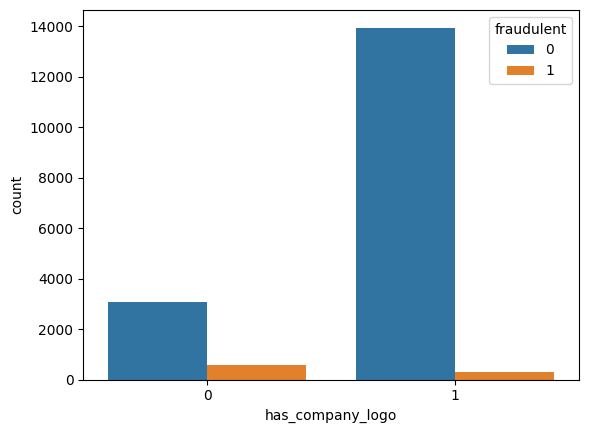

In [57]:
sns.countplot(x='has_company_logo',data=dataset,hue='fraudulent')

<Axes: xlabel='has_questions'>

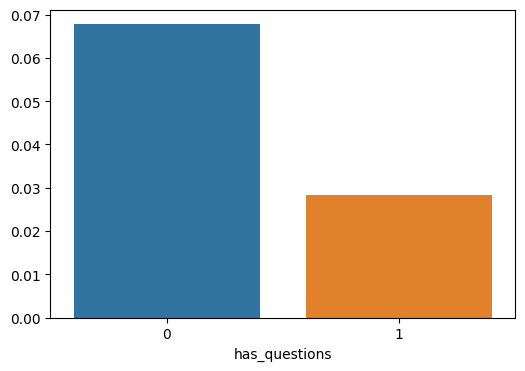

In [58]:
#has_questions
has_questions_fraud = dataset.groupby('has_questions')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=has_questions_fraud.index, y=has_questions_fraud.values, ax=ax)

<Axes: xlabel='has_questions', ylabel='count'>

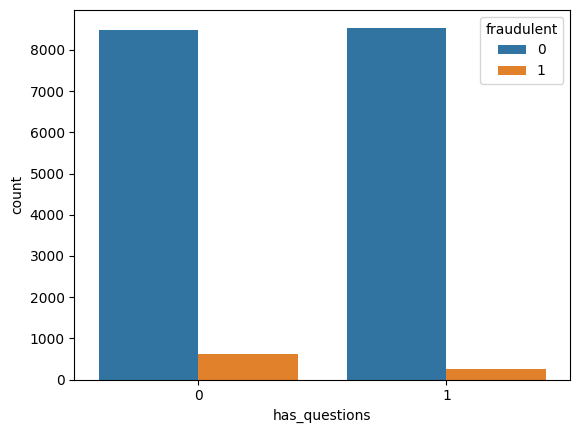

In [59]:
sns.countplot(x='has_questions',data=dataset,hue='fraudulent')

<Axes: xlabel='employment_type'>

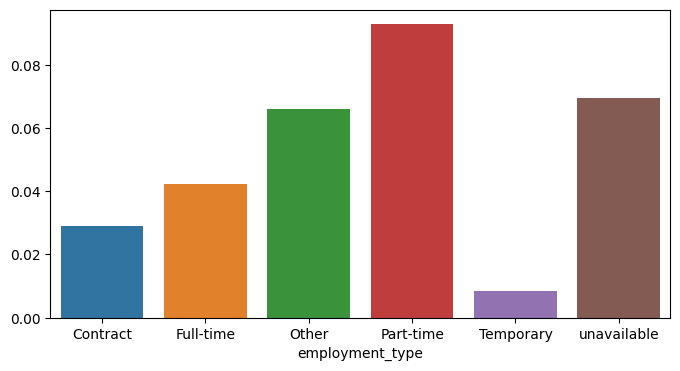

In [60]:
#employment_type
employment_type_fraud = dataset.groupby('employment_type')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.barplot(x=employment_type_fraud.index, y=employment_type_fraud.values, ax=ax)

<Axes: xlabel='employment_type', ylabel='count'>

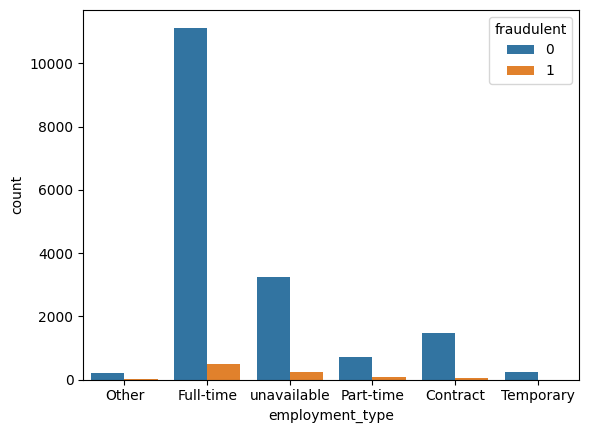

In [61]:
sns.countplot(x='employment_type',data=dataset,hue='fraudulent')

<Axes: xlabel='required_experience'>

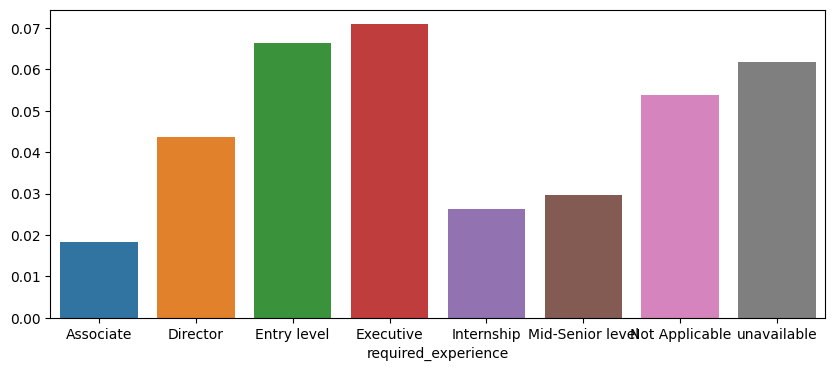

In [62]:
#required_experience
required_experience_fraud = dataset.groupby('required_experience')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(10,4))
sns.barplot(x=required_experience_fraud.index, y=required_experience_fraud.values, ax=ax)

<Axes: xlabel='required_experience', ylabel='count'>

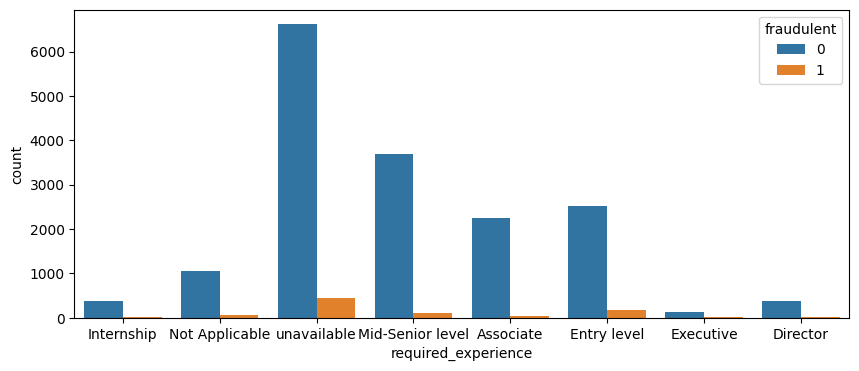

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
sns.countplot(x='required_experience',data=dataset,hue='fraudulent',ax=ax)

In [64]:
#required_education
dataset[dataset['fraudulent']==1]['required_education'].value_counts().head(5)

required_education
unavailable                  451
High School or equivalent    170
Bachelor's Degree            100
Unspecified                   61
Master's Degree               31
Name: count, dtype: int64

In [65]:
dataset[dataset['fraudulent']==0]['required_education'].value_counts().head(5)

required_education
unavailable                  7654
Bachelor's Degree            5045
High School or equivalent    1910
Unspecified                  1336
Master's Degree               385
Name: count, dtype: int64

In [66]:
#industry
dataset[dataset['fraudulent']==1]['industry'].value_counts().head(5)

industry
unavailable                  275
Oil & Energy                 109
Accounting                    57
Hospital & Health Care        51
Marketing and Advertising     45
Name: count, dtype: int64

In [67]:
dataset[dataset['fraudulent']==0]['industry'].value_counts().head(5)

industry
unavailable                            4628
Information Technology and Services    1702
Computer Software                      1371
Internet                               1062
Education Management                    822
Name: count, dtype: int64

In [68]:
#function
dataset[dataset['fraudulent']==1]['function'].value_counts().head(5)

function
unavailable         337
Administrative      119
Engineering         113
Customer Service     67
Sales                41
Name: count, dtype: int64

In [69]:
dataset[dataset['fraudulent']==0]['function'].value_counts().head(5)

function
unavailable               6118
Information Technology    1717
Sales                     1427
Engineering               1235
Customer Service          1162
Name: count, dtype: int64

## 3. Preprocessing

- frequency encoding: title,department,salary_range,industry,function
- embeddings: company_profile,description,requirements,benefits
- one-hot encoding: others
- location: split(',') then frequency encoding

- need to strip() text
- for text dataset:  1) combine all text together and get embeddings; 2) deal with them separately and for department-like features, use frequency encoding

In [70]:
df = dataset

#df = dataset.copy()

In [71]:
# if company_profile is null, more likely to be fraudulent
dataset[dataset['company_profile'].isna()]['fraudulent'].mean()

nan

In [72]:
dataset[~dataset['company_profile'].isna()]['fraudulent'].mean()

0.04843400447427293

In [73]:
df['company_profile_isna'] = df['company_profile'].isna().replace({True: 1, False: 0})

### 3.1 Deal with missing values

In [74]:
# drop when description is null, only 1 record
df = df.dropna(subset=['description'])

In [75]:
# combine texts
df[['company_profile']] = df[['company_profile']].fillna('')
df[['description']] = df[['description']].fillna('')
df[['requirements']] = df[['requirements']].fillna('')
df[['benefits']] = df[['benefits']].fillna('')
df['full_text'] = df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']

del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']

df.head()

,title,location,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,have_company_profile,have_requirements,have_benefits,have_department,full_text,location_country,location_county,location_city,salary_group,text_len,company_profile_isna
0,Marketing Intern,"US, NY, New York",Marketing,Unavailable,0,1,0,Other,Internship,unavailable,unavailable,Marketing,0,1,1,0,1,"We're Food52, and we've created a groundbreaki...",US,NY,New York,Unavailable,258,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,Unavailable,0,1,0,Full-time,Not Applicable,unavailable,Marketing and Advertising,Customer Service,0,1,1,1,1,"90 Seconds, the worlds Cloud Video Production ...",NZ,,Auckland,Unavailable,590,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Unavailable,0,1,0,unavailable,unavailable,unavailable,unavailable,unavailable,0,1,1,0,0,Valor Services provides Workforce Solutions th...,US,IA,Wever,Unavailable,232,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Unavailable,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,1,1,1,1,Our passion for improving quality of life thro...,US,DC,Washington,Unavailable,493,0
4,Bill Review Manager,"US, FL, Fort Worth",,Unavailable,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,1,1,1,0,SpotSource Solutions LLC is a Global Human Cap...,US,FL,Fort Worth,Unavailable,400,0


In [76]:
df[['location_country','location_county','location_city']] = df[['location_country','location_county','location_city']].replace(' ',np.NaN)

In [77]:
# fill in with 'unknown': location_country,county,city,employment_type,required_experience,required_education,industry,function
df[['employment_type','required_experience','required_education','industry','function','location_country','location_county','location_city']] \
= df[['employment_type','required_experience','required_education','industry','function','location_country','location_county','location_city']].fillna('Unknown')

In [78]:
# bin then fill in with most common: salary_group, but still keep salary_range, fill in with 'unknown' and use frequency encoding
df['salary_group'] = df['salary_range']

In [79]:
for idx in (df['salary_group'].dropna()).index:
    Range = df.at[idx , 'salary_group'].split('-')
    try :
        starts = int(Range[0])
        if len(Range)==2:
          ends = int(Range[1])
        else:
          ends = starts
        salary = (starts + ends)/2
        if salary <= 1000:
          df.at[idx ,'salary_group'] = 'Extremely Low'
        elif salary > 1000 and salary <= 30000:
          df.at[idx ,'salary_group'] = 'Low'
        elif salary > 30000 and salary <= 100000:
          df.at[idx ,'salary_group'] = 'Slightly Low'
        elif salary > 100000 and salary <= 500000:
          df.at[idx ,'salary_group'] = 'Slightly High'
        elif salary > 500000 and salary <= 1000000:
          df.at[idx ,'salary_group'] = 'High'
        elif salary > 1000000:
          df.at[idx ,'salary_group'] = 'Extremely High'

    except ValueError:
        df.at[idx ,'salary_group'] = 'Unknown'

df['salary_group'] = df['salary_group'].fillna('Unknown')
df['salary_range'] = df['salary_range'].fillna('Unknown')

In [80]:
df.groupby('salary_group')['fraudulent'].mean()

salary_group
Extremely High    0.052632
Extremely Low     0.078035
High              0.312500
Low               0.090062
Slightly High     0.053292
Slightly Low      0.073549
Unknown           0.042825
Name: fraudulent, dtype: float64

In [81]:
df[df['fraudulent']==1]['salary_group'].value_counts()

salary_group
Unknown           644
Slightly Low      109
Low                58
Extremely Low      27
Slightly High      17
High               10
Extremely High      1
Name: count, dtype: int64

In [82]:
df[df['fraudulent']==0]['salary_group'].value_counts()

salary_group
Unknown           14394
Slightly Low       1373
Low                 586
Extremely Low       319
Slightly High       302
High                 22
Extremely High       18
Name: count, dtype: int64

In [83]:
# department & location, drop
df = df.drop(['location','department'],axis=1)

In [84]:
df.isna().sum()

title                   0
salary_range            0
telecommuting           0
has_company_logo        0
has_questions           0
employment_type         0
required_experience     0
required_education      0
industry                0
function                0
fraudulent              0
have_company_profile    0
have_requirements       0
have_benefits           0
have_department         0
full_text               0
location_country        0
location_county         0
location_city           0
salary_group            0
text_len                0
company_profile_isna    0
dtype: int64

In [85]:
fraud_text = df[df.fraudulent == 1].full_text
nonfraud_text = df[df.fraudulent == 0].full_text


In [124]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(fraud_text)))
plt.imshow(wc,interpolation = 'bilinear')


AttributeError: 'TransposedFont' object has no attribute 'getbbox'

<Figure size 1600x800 with 0 Axes>

In [125]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(nonfraud_text)))
plt.imshow(wc,interpolation = 'bilinear')


AttributeError: 'TransposedFont' object has no attribute 'getbbox'

<Figure size 1600x800 with 0 Axes>

### 3.2 Clean text data

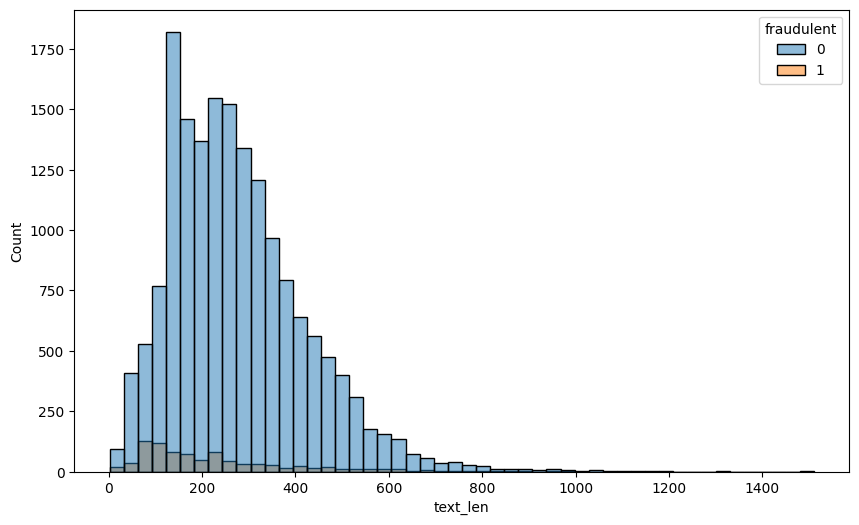

In [89]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="text_len", hue="fraudulent", kde=False, bins=50)
plt.show()

In [90]:
df['text_len'].describe()

count    17880.000000
mean       272.953300
std        147.869521
min          2.000000
25%        162.000000
50%        249.000000
75%        353.000000
max       1511.000000
Name: text_len, dtype: float64

In [91]:
df[df['fraudulent']==0]['text_len'].describe()

count    17014.000000
mean       275.525038
std        146.625583
min          7.000000
25%        165.000000
50%        252.000000
75%        355.000000
max       1511.000000
Name: text_len, dtype: float64

In [92]:
df[df['fraudulent']==1]['text_len'].describe()

count    866.000000
mean     222.427252
std      162.511161
min        2.000000
25%      105.000000
50%      180.000000
75%      293.000000
max      987.000000
Name: text_len, dtype: float64

### 3.3 train-test-split

In [94]:
#train test split
from sklearn.model_selection import train_test_split
X = df.drop('fraudulent',axis=1)
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023,stratify=y)

### 3.4 Encoding

In [100]:
# ordinal encoding for salary_group

from sklearn.preprocessing import OrdinalEncoder

ordinal = OrdinalEncoder(
    categories = [['Extremly Low','Low','Sligtly Low','Slightly High','High','Extremly High' ]],  # order of the categorical values
    handle_unknown = 'use_encoded_value',  #  what to do for unknown values not in the categories list
    unknown_value = -1 # what to replace these unknown values with
)

ordinal.fit_transform(X_train[['salary_group']])

array([[-1.],
       [-1.],
       [-1.],
       ...,
       [-1.],
       [-1.],
       [-1.]])

In [116]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(
    categories = [
            ['Full-time', 'Contract', 'Part-time','Temporary','Other','unavailable'], # employment_type
            ['unavailable', 'Mid-Senior level', 'Entry level', 'Associate', 'Not Applicable', 'Director', 'Internship', 'Executive'], # required_experience
            ['unavailable',"Bachelor's Degree",'High School or equivalent','Unspecified',"Master's Degree",'Associate Degree','Certification','Some College Coursework Completed','Vocational','Professional','Doctorate','Some High School Coursework','Vocational - Degree','Vocational - HS Diploma','Vocational - Other','None','Vocational - HS Certificate','Vocational - Bachelor','Vocational - Master'], # required_education
            ['Information Technology and Services', 'Computer Software','Internet','Marketing and Advertising','Education Management','Financial Services','Hospital & Health Care','Consumer Services','Telecommunications','Oil & Energy','Retail','Real Estate','Accounting','Construction'], # Industry
            ['unavailable','Information Technology','Sales','Engineering','Customer Service','Marketing','Administrative','Design','Health Care Provider','Other','Education','Management','Business Development','Accounting/Auditing','Human Resources','Project Management','Finance','Consulting','Writing/Editing','Art/Creative','Production','Quality Assurance','Data Analyst','Research','Manufacturing','Advertising','Public Relations','Legal','Distribution','Product Management','Strategy/Planning','Purchasing','General Business','Science','Supply Chain','Training','Financial Analyst','Biotech','Inventory','Information Technology','Facilities','QA','Skilled Labor','Business Development','Research Development','Science','Professional Services','Design','Product Management','Strategy/Planning','Purchasing','General Business','Supply Chain','Training','Financial Analyst','Biotech','Inventory','Facilities','QA','Skilled Labor','Research Development','Professional Services','Logistics','Nonprofit','Operations Management','Nurse','Pharmaceutical'], # function
            ['US','GB','GR','CA','DE'] # location_country
     ],
     handle_unknown = 'ignore',  # <- Ignore unknown values (i.e. don't create a column for them)
)

onehot.fit_transform(X_train[[ 'employment_type', 'required_experience','required_education','industry','function','location_country']])

<12516x119 sparse matrix of type '<class 'numpy.float64'>'
	with 66533 stored elements in Compressed Sparse Row format>

In [117]:
pd.DataFrame.sparse.from_spmatrix(
    data = onehot.fit_transform(X_train[['employment_type', 'required_experience','required_education','industry','function','location_country']]),  # <- sparse matrix
    columns = onehot.get_feature_names_out(),                        # <- encoded features
    index = X_train.index
)

,employment_type_Full-time,employment_type_Contract,employment_type_Part-time,employment_type_Temporary,employment_type_Other,employment_type_unavailable,required_experience_unavailable,required_experience_Mid-Senior level,required_experience_Entry level,required_experience_Associate,required_experience_Not Applicable,required_experience_Director,required_experience_Internship,required_experience_Executive,required_education_unavailable,required_education_Bachelor's Degree,required_education_High School or equivalent,required_education_Unspecified,required_education_Master's Degree,required_education_Associate Degree,required_education_Certification,required_education_Some College Coursework Completed,required_education_Vocational,required_education_Professional,required_education_Doctorate,required_education_Some High School Coursework,required_education_Vocational - Degree,required_education_Vocational - HS Diploma,required_education_Vocational - Other,required_education_None,required_education_Vocational - HS Certificate,required_education_Vocational - Bachelor,required_education_Vocational - Master,industry_Information Technology and Services,industry_Computer Software,industry_Internet,industry_Marketing and Advertising,industry_Education Management,industry_Financial Services,industry_Hospital & Health Care,industry_Consumer Services,industry_Telecommunications,industry_Oil & Energy,industry_Retail,industry_Real Estate,industry_Accounting,industry_Construction,function_unavailable,function_Information Technology,function_Sales,function_Engineering,function_Customer Service,function_Marketing,function_Administrative,function_Design,function_Health Care Provider,function_Other,function_Education,function_Management,function_Business Development,function_Accounting/Auditing,function_Human Resources,function_Project Management,function_Finance,function_Consulting,function_Writing/Editing,function_Art/Creative,function_Production,function_Quality Assurance,function_Data Analyst,function_Research,function_Manufacturing,function_Advertising,function_Public Relations,function_Legal,function_Distribution,function_Product Management,function_Strategy/Planning,function_Purchasing,function_General Business,function_Science,function_Supply Chain,function_Training,function_Financial Analyst,function_Biotech,function_Inventory,function_Information Technology,function_Facilities,function_QA,function_Skilled Labor,function_Business Development,function_Research Development,function_Science,function_Professional Services,function_Design,function_Product Management,function_Strategy/Planning,function_Purchasing,function_General Business,function_Supply Chain,function_Training,function_Financial Analyst,function_Biotech,function_Inventory,function_Facilities,function_QA,function_Skilled Labor,function_Research Development,function_Professional Services,function_Logistics,function_Nonprofit,function_Operations Management,function_Nurse,function_Pharmaceutical,location_country_US,location_country_GB,location_country_GR,location_country_CA,location_country_DE
11917,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4640,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [118]:
df.columns

Index(['title', 'salary_range', 'telecommuting', 'has_company_logo',
       'has_questions', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent',
       'have_company_profile', 'have_requirements', 'have_benefits',
       'have_department', 'full_text', 'location_country', 'location_county',
       'location_city', 'salary_group', 'text_len', 'company_profile_isna'],
      dtype='object')

In [120]:
# Combine them!

numerical_columns = ['telecommuting', 'has_company_logo','has_questions','have_company_profile', 'have_requirements', 'have_benefits','have_department','text_len','company_profile_isna' ]  # numerical columns
ordinal_columns = ['salary_group']        # categorical columns for ordinal encoding
onehot_columns = ['employment_type', 'required_experience','required_education','industry','function','location_country']                   # categorical columns for onehot encoding

from sklearn.compose import ColumnTransformer
encoder = ColumnTransformer([
   #(nickname, transformer to apply, columns to apply to)   
    ('numerical', 'passthrough', numerical_columns),   # <- 'passthrough' says to keep them but don't apply anything
    ('ordinal', ordinal, ordinal_columns),             # <- apply ordinal encoder to the ordinal_columns
    ('onehot', onehot, onehot_columns)                 # <- apply onehot encoder to the onehot_columns
])

encoder

ColumnTransformer(transformers=[('numerical', 'passthrough',
                                 ['telecommuting', 'has_company_logo',
                                  'has_questions', 'have_company_profile',
                                  'have_requirements', 'have_benefits',
                                  'have_department', 'text_len',
                                  'company_profile_isna']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['Extremly Low',
                                                             'Low',
                                                             'Sligtly Low',
                                                             'Slightly High',
                                                             'High',
                                                             'Extremly High']],
                                                handle_unknown=...
                                                            'Consulting',
                                                            'Writing/Editing',
                                                            'Art/Creative',
                                                            'Production',
                                                            'Quality Assurance',
                                                            'Data Analyst',
                                                            'Research',
                                                            'Manufacturing',
                                                            'Advertising',
                                                            'Public Relations',
                                                            'Legal',
                                                            'Distribution',
                                                            'Product '
                                                            'Management', ...],
                                                           ['US', 'GB', 'GR',
                                                            'CA', 'DE']],
                                               handle_unknown='ignore'),
                                 ['employment_type', 'required_experience',
                                  'required_education', 'industry', 'function',
                                  'location_country'])])

### 3.5 Get embeddings

In [ ]:
## pre trained
## tokenized, embedding layer